<a href="https://colab.research.google.com/github/NunezKant/iGEDS/blob/master/GED_141_Countries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se incluyen librerías necesarias:

In [ ]:
! pip install pingouin
! pip install pycaret
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns


Cargamos los datos:

In [3]:
df = pd.read_excel('https://github.com/NunezKant/iGEDS/blob/master/iEcosystems%20(106%20countries%20dataset).xlsx?raw=true', decimal = ',', sheet_name=0)
df.tail()

,Country,Region,Development Stage,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),2.01a Percentage of adults with a doctoral or equivalent level of education (OECD),2.01b Skillset of graduates (GCI 4.0),2.01c Ease of finding skilled employees (GCI 4.0),2.01d Researchers/Professionals engaged in R&D per million population (GII),"2.01e STEM Graduates per capita (OECD) - Natural sciences, mathematics and statistics",2.02a R&D expenditure as a % GDP (UNESCO),2.02b R&D expenditure in '000 current PPP$ (UNESCO),2.02c Public R&D Expenditure as % of GDP (UNESCO),2.02d Business R&D Expenditure as % GDP (UNESCO),2.03a Internet Bandwidth (GCI),2.03b Production Process Sophistication (GCI),2.03c Availability of latest technologies (GCI),2.03d ICT access (GII),2.04a Government procurement of advanced technology (GCI),2.04b University-industry research collaborations (GII),"2.04c Trade, Competition & Market scale (GII)",2.05a Research institutions prominence (GCI 4.0),2.05b Graduates in science & engineering (%) (GII),3.01a Entrepreneurship perceived capabilities (GEM),3.01b % school grads in tertiary education (GII),3.02a VC investment (WEF),3.02b Financing of SME's (GCI 4.0),3.02c Venture Capital Availability (GCI 4.0),3.02d Ease of Credit (GII),3.02e VC deals (GII),3.02f Venture Capital Deal Volume (WEF),3.03a Logistics performance (WB),3.03b Electricity (GCI 4.0),3.03c ICT Adoption (GCI 4.0),3.04a Buyer sophistication (GCI 4.0),3.04b Domestic Market Scale (GII),3.05a Entrepreneurial intentions (GEM),3.05b Fear of failure (GEM),3.05c Entrepreneurship as a Good Career choice (GEM),3.05d High Status to Successful Entrepreneurs (GEM),3.05e Business Freedom (IEF),3.05f Attitudes towards Entrepreneurial Risk (GCI 4.0),4.01 State of cluster development (GCI 4.0),4.02 Country capacity to attract and retain talent (WEF),5.01 Social Progress Index (SPI),5.02 Inclusive Development Index (IDI),5.03 Population below international poverty line (SDG 1 - No poverty),5.04 Prevalence of undernourishment (SDG 2 - Zero Hunger),"5.05 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)",5.06 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities),5.07 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities),5.08 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production),6.01 GDP per capita (IMF),6.02 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth),6.03 Annual growth rate of GDP (WB),6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG)
103,Uruguay,Latin America and the Caribbean,Developing economies,61.5,89.6,70.3,53.6,56.3,72.0,73.5,71.0,77.4,70,NaN,54.44,51.97,8.0,NaN,0.48393,3.779874e+05,0.17,0.12,96.71,3.53,4.85,75.1,2.84,34.9,52.8,0.44,11.7,58.97,49.0,1.8,50.13,35.96,60,NaN,97.6,2.78,95.22,79.73,44.54,42.5,24.21,27.39,54.68,49.56,73.6,41.46,40.80,3.0,77.77,4.46,0.1,2.5,0.09,NaN,8.629750,34.47499,17164.89,2.28,0.2,7.9,-1.05,16230,64.0
104,Vietnam,East Asia and Pacific,Developing economies,69.8,85.1,69.0,38.0,62.1,52.6,33.8,62.5,79.6,33,NaN,41.25,49.31,8.4,NaN,0.52674,3.417199e+06,0.11,0.38,91.25,3.49,3.96,48.8,3.64,38.6,69.3,4.23,38.1,NaN,21.9,14.0,43.73,37.79,75,8.1,2712.8,3.16,96.17,69.03,47.80,64.6,NaN,NaN,NaN,NaN,65.6,48.47,52.62,3.5,NaN,3.98,2.0,10.8,0.35,27.2,29.655321,10.98522,2551.12,5.73,7.0,1.9,6.34,2540,50.2
105,Zambia,Sub-Saharan Africa,Least developed countries,66.9,84.9,88.9,49.3,50.8,45.2,28.4,47.0,72.6,35,NaN,45.98,62.69,

In [4]:
pillars = pd.read_excel('https://github.com/NunezKant/iGEDS/blob/master/iEcosystems%20(106%20countries%20dataset).xlsx?raw=true', decimal = ',', sheet_name=1)
pillars = pillars['Pillar'].values


*   Guardamos minimos y maximos
*   Eliminamos dichas filas del df
*   Hacemos set del país como indice del df



In [5]:
mins = df.iloc[-2,3:].astype('float').values
maxs = df.iloc[-1,3:].astype('float').values
df = df.drop(axis = 0, index=[106,107])
df.set_index('Country', inplace = True)

In [6]:
df.tail()

,Region,Development Stage,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),2.01a Percentage of adults with a doctoral or equivalent level of education (OECD),2.01b Skillset of graduates (GCI 4.0),2.01c Ease of finding skilled employees (GCI 4.0),2.01d Researchers/Professionals engaged in R&D per million population (GII),"2.01e STEM Graduates per capita (OECD) - Natural sciences, mathematics and statistics",2.02a R&D expenditure as a % GDP (UNESCO),2.02b R&D expenditure in '000 current PPP$ (UNESCO),2.02c Public R&D Expenditure as % of GDP (UNESCO),2.02d Business R&D Expenditure as % GDP (UNESCO),2.03a Internet Bandwidth (GCI),2.03b Production Process Sophistication (GCI),2.03c Availability of latest technologies (GCI),2.03d ICT access (GII),2.04a Government procurement of advanced technology (GCI),2.04b University-industry research collaborations (GII),"2.04c Trade, Competition & Market scale (GII)",2.05a Research institutions prominence (GCI 4.0),2.05b Graduates in science & engineering (%) (GII),3.01a Entrepreneurship perceived capabilities (GEM),3.01b % school grads in tertiary education (GII),3.02a VC investment (WEF),3.02b Financing of SME's (GCI 4.0),3.02c Venture Capital Availability (GCI 4.0),3.02d Ease of Credit (GII),3.02e VC deals (GII),3.02f Venture Capital Deal Volume (WEF),3.03a Logistics performance (WB),3.03b Electricity (GCI 4.0),3.03c ICT Adoption (GCI 4.0),3.04a Buyer sophistication (GCI 4.0),3.04b Domestic Market Scale (GII),3.05a Entrepreneurial intentions (GEM),3.05b Fear of failure (GEM),3.05c Entrepreneurship as a Good Career choice (GEM),3.05d High Status to Successful Entrepreneurs (GEM),3.05e Business Freedom (IEF),3.05f Attitudes towards Entrepreneurial Risk (GCI 4.0),4.01 State of cluster development (GCI 4.0),4.02 Country capacity to attract and retain talent (WEF),5.01 Social Progress Index (SPI),5.02 Inclusive Development Index (IDI),5.03 Population below international poverty line (SDG 1 - No poverty),5.04 Prevalence of undernourishment (SDG 2 - Zero Hunger),"5.05 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)",5.06 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities),5.07 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities),5.08 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production),6.01 GDP per capita (IMF),6.02 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth),6.03 Annual growth rate of GDP (WB),6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG)
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
United Kingdom,Europe and Central Asia,Developed economies,83.5,94.6,86.2,80.3,68.7,92.2,89.9,73.1,86.4,80,1.36,62.25,67.51,53.0,26.319796,1.72412,5.214629e+07,0.11,1.19,449.14,5.87,6.30,92.9,3.91,72.7,82.0,100.00,48.3,55.18,46.7,146.3,62.57,57.93,75,76.3,413438.1,4.01,98.21,72.99,62.08,79.1,7.62,44.49,56.38,76.67,94.7,65.34,65.91,5.7,87.98,4.89,0.2,2.5,0.15,NaN,10.525446,7.78539,42558.00,1.14,1.4,4.3,2.29,42370,76.1
United States,North America,Developed economies,84.0,91.6,86.8,90.5,73.4,81.8,77.2,87.9,79.8,71,1.97,71.20,72.06,51.5,17.920212,2.83766,5.815530e+08,0.29,2.06,126.55,5.94,6.46,84.8,5.09,80.9,92.7,100.00,24.8,65.51,70.1,117.9,74.77,70.58,95,100.0,2121482.0,3.92,99.29,74.35,68.75,97.9,13.68,35.10,67.87,79.66,83.3,75.88,74.75,5.8,83.62,4.60,1.2,2.5,0.29,NaN,7.395344,18.60373,62605.59,1.50,2.3,4.4,1.22,65760,76.3
Uruguay,Latin America a

Re-escalamos a valores entre 1-5 

In [7]:
columns = df.select_dtypes(include='number').columns.values

for col,val1,val2 in zip(columns,mins,maxs):
  df[col] = df[col].apply(lambda x: (x-val1)/(val2-val1))

scaled = (df.select_dtypes(include='number')*4)+1

Inputamos por método de KNN con 5 vecinos como parámetro, los valores fuera de los limites dados, se toparon a 1 o 5 respectivamente.

In [8]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
var = imputer.fit_transform(scaled)
var = np.where(var>5,5,var)
var = np.where(var<1,1,var)
df_imputed = pd.DataFrame(var)
df_imputed.columns = scaled.columns
df_imputed.index = scaled.index
df_imputed.head(6)

,1.01 Ease of doing business (WB),1.02 Starting a business (WB),1.03 Paying taxes (WB),1.04 Resolving Insolvency (WB),1.05 Enforcing contracts (WB),1.06 Property Rights (IEF),1.07 Government Integrity (IEF),1.08 Labor Freedom (IEF),1.09 Trade freedom (IEF),1.10 Corruption Perceptions Index (TI),2.01a Percentage of adults with a doctoral or equivalent level of education (OECD),2.01b Skillset of graduates (GCI 4.0),2.01c Ease of finding skilled employees (GCI 4.0),2.01d Researchers/Professionals engaged in R&D per million population (GII),"2.01e STEM Graduates per capita (OECD) - Natural sciences, mathematics and statistics",2.02a R&D expenditure as a % GDP (UNESCO),2.02b R&D expenditure in '000 current PPP$ (UNESCO),2.02c Public R&D Expenditure as % of GDP (UNESCO),2.02d Business R&D Expenditure as % GDP (UNESCO),2.03a Internet Bandwidth (GCI),2.03b Production Process Sophistication (GCI),2.03c Availability of latest technologies (GCI),2.03d ICT access (GII),2.04a Government procurement of advanced technology (GCI),2.04b University-industry research collaborations (GII),"2.04c Trade, Competition & Market scale (GII)",2.05a Research institutions prominence (GCI 4.0),2.05b Graduates in science & engineering (%) (GII),3.01a Entrepreneurship perceived capabilities (GEM),3.01b % school grads in tertiary education (GII),3.02a VC investment (WEF),3.02b Financing of SME's (GCI 4.0),3.02c Venture Capital Availability (GCI 4.0),3.02d Ease of Credit (GII),3.02e VC deals (GII),3.02f Venture Capital Deal Volume (WEF),3.03a Logistics performance (WB),3.03b Electricity (GCI 4.0),3.03c ICT Adoption (GCI 4.0),3.04a Buyer sophistication (GCI 4.0),3.04b Domestic Market Scale (GII),3.05a Entrepreneurial intentions (GEM),3.05b Fear of failure (GEM),3.05c Entrepreneurship as a Good Career choice (GEM),3.05d High Status to Successful Entrepreneurs (GEM),3.05e Business Freedom (IEF),3.05f Attitudes towards Entrepreneurial Risk (GCI 4.0),4.01 State of cluster development (GCI 4.0),4.02 Country capacity to attract and retain talent (WEF),5.01 Social Progress Index (SPI),5.02 Inclusive Development Index (IDI),5.03 Population below international poverty line (SDG 1 - No poverty),5.04 Prevalence of undernourishment (SDG 2 - Zero Hunger),"5.05 Carbon dioxide emissions per unit of GDP (SDG 9 - Industry, Innovation and Infrastructure)",5.06 Proportion of urban population living in slums (SDG 11 - Sustainable Cities and Communities),5.07 Annual population-weighted average mean concentration of fine suspended particles of less than 2.5 microns in diameter (SDG 11 - Sustainable Cities and Communities),5.08 Domestic material consumption per capita (SDG 12 - Responsible Consumption and Production),6.01 GDP per capita (IMF),6.02 Annual growth rate of real GDP per capita (SDG 8 - Decent Jobs and Economic Growth),6.03 Annual growth rate of GDP (WB),6.04 Unemployment rate of population 15 years of age and older (SDG 8 - Decent Jobs and Economic Growth),6.05 FDI inward flow as % of GDP (UNCTAD),GNI per capita (WB),SEDA Score (BCG)
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albania,3.708,4.672,3.608,3.708,3.140,3.284,2.552,3.084,4.536,2.44,1.464935,3.1964,2.9276,1.0680,2.372973,1.292374,1.005049,1.765957,1.160000,1.045038,2.986667,3.240000,3.124,2.933333,2.552,3.304,1.0000,2.132,3.812743,2.788,1.099796,2.9052,2.3428,3.8,1.0984,1.000581,2.62,4.7012,3.1152,2.3820,2.356,2.904263,2.728257,3.492823,3.309996,3.628,2.5604,2.2156,1.933333,3.8628,3.053333,4.942559,4.704433,4.636364,4.334750,4.342004,1.846966,1.239117,3.832817,2.676190,2.549550,3.394919,1.236727,3.172
Algeria,2.944,4.120,3.156,2.968,3.192,2.516,2.132,3.020,3.648,2.40,1.384416,2.7920,3.0812,1.3920,2.327889,1.430297,1.024607,3.212766,1.031169,1.031214,2.526667,2.853333,3.124,2.340000,2.076,3.304,1.3912,3.464,3.869464,2.496,1.258656,2.8780,2.6564,1.4,1.2176,1.022620,2.56,4.7512,3.1088,2.8556,3.556,3.244305,3.082384,3.498782,4.021330,3.520,2.7396,2.9316,1.866667,3.6824,3.146667,4.973890,4

In [9]:
df_togroup = df_imputed.T
df_togroup['Pillar'] = pillars
df_togroup.head()

Country,Albania,Algeria,Argentina,Armenia,Australia,Austria,Azerbaijan,Bangladesh,Belgium,Bosnia and Herzegovina,Brazil,Bulgaria,Burundi,Cambodia,Cameroon,Canada,Chile,China,Colombia,Costa Rica,Croatia,Cyprus,Czech Republic,Denmark,Dominican Republic,Ecuador,"Egypt, Arab Rep.",El Salvador,Estonia,Ethiopia,Finland,France,Georgia,Germany,Ghana,Greece,Guatemala,Honduras,Hungary,Iceland,...,Netherlands,New Zealand,Nigeria,North Macedonia,Norway,Oman,Pakistan,Panama,Paraguay,Peru,Philippines,Poland,Portugal,Qatar,Romania,Russian Federation,Rwanda,Saudi Arabia,Senegal,Serbia,Singapore,Slovak Republic,Slovenia,South Africa,Spain,Sri Lanka,Sweden,Switzerland,Tanzania,Thailand,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States,Uruguay,Vietnam,Zambia,Pillar
1.01 Ease of doing business (WB),3.708,2.944,3.360,3.980,4.248,4.148,4.068,2.800,4.000,3.616,3.364,3.880,2.872,3.152,2.844,4.184,3.904,4.116,3.804,3.768,3.944,3.936,4.052,4.412,3.400,3.308,3.404,3.612,4.224,2.920,4.208,4.072,4.348,4.188,3.400,3.736,3.504,3.252,3.936,4.160,...,4.044,4.472,3.276,4.228,4.304,3.800,3.440,3.664,3.364,3.748,3.512,4.056,4.060,3.748,3.932,4.128,4.060,3.864,3.372,4.028,4.448,4.024,4.060,3.680,4.116,3.472,4.280,4.064,3.180,4.204,3.748,4.072,3.808,4.236,4.340,4.360,3.460,3.792,3.676,1 Foundational Institutions
1.02 Starting a business (WB),4.672,4.120,4.216,4.844,4.864,4.328,4.848,4.296,4.692,3.400,4.252,4.416,4.716,3.096,4.452,4.928,4.656,4.764,4.480,4.196,4.412,4.680,4.284,4.708,4.416,3.764,4.512,4.144,4.816,3.868,4.740,4.724,4.984,4.348,4.400,4.840,4.472,3.856,4.528,4.624,...,4.772,5.000,4.448,4.544,4.772,4.740,4.572,4.680,4.040,4.284,3.852,4.316,4.636,4.444,4.508,4.724,4.728,4.724,4.648,4.572,4.928,4.392,4.720,4.248,4.476,4.528,4.724,4.536,3.976,4.696,4.784,4.552,4.644,4.792,4.784,4.664,4.584,4.404,4.396,1 Foundational Institutions
1.03 Paying taxes (WB),3.608,3.156,2.972,4.260,4.428,4.340,4.360,3.244,4.136,3.416,2.376,3.892,3.436,3.452,2.452,4.524,4.012,3.804,3.344,4.120,4.272,4.420,4.256,4.644,3.296,3.344,3.204,4.100,4.596,3.532,4.636,4.168,4.568,4.288,3.240,4.084,3.812,2.996,4.224,4.352,...,4.496,4.640,3.148,4.388,4.404,4.608,3.116,2.868,3.564,3.632,3.904,4.056,4.348,4.976,4.408,4.220,4.384,4.220,3.048,4.012,4.664,4.224,4.332,4.248,4.388,3.392,4.412,4.508,3.052,4.108,3.776,4.464,4.124,4.412,4.448,4.472,3.812,3.760,4.556,1 Foundational Institutions
1.04 Resolving Insolvency (WB),3.708,2.968,2.600,2.784,4.156,4.096,3.540,2.124,4.364,3.728,3.016,3.312,2.224,2.940,2.464,4.240,3.404,3.484,3.856,2.384,3.260,3.900,4.204,4.404,2.520,2.020,2.688,2.824,3.404,2.212,4.708,3.984,3.248,4.592,2.016,3.124,2.104,2.304,3.200,4.280,...,4.376,3.780,2.224,3.908,4.416,2.760,3.360,2.580,2.684,2.864,3.204,4.060,4.208,2.520,3.364,3.364,3.288,1.000,2.772,3.680,3.972,3.620,4.376,3.184,4.168,2.800,4.180,3.504,2.564,4.072,3.168,2.540,2.256,2.972,4.212,4.620,3.144,2.520,2.972,1 Foundational Institutions
1.05 Enforcing contracts (WB),3.140,3.192,3.300,3.788,4.160,4.020,3.812,1.888,3.572,3.312,3.564,3.680,2.720,2.268,2.596,3.284,3.588,4.236,2.372,3.208,3.824,2.944,3.256,3.956,3.024,3.300,2.600,3.076,4.044,3.512,3.656,3.940,4.000,3.964,3.160,2.924,2.380,2.768,3.840,3.764,...,3.396,3.860,3.460,3.640,4.252,3.476,2.740,2.960,3.464,3.364,2.840,3.576,3.716,3.184,3.888,3.888,3.764,3.612,3.024,3.524,4.380,3.644,3.192,3.276,3.836,2.648,3.704,3.564,3.468,3.716,3.336,3.856,3.544,4.036,3.748,3.936,3.252,3.484,3.032,1 Foundational Institutions


In [10]:
df_grouped = df_togroup.groupby('Pillar').mean()
df_grouped = df_grouped.T
df_grouped.head()

Pillar,1 Foundational Institutions,2.01 I-Human Capital,2.02 I-Funding,2.03 I-Infrastructure,2.04 I-Demand,2.05 I-Culture & Incentives,3.01 E-Human Capital,3.02 E-Funding,3.03 E-Infrastructure,3.04 E-Demand,3.05 E-Culture & Incentives,4 Comparative Advantage,5 Social Impact,6 Economic Impact,GNI per capita,SEDA Score
Country,,,,,,,,,,,,,,,,
Albania,3.4732,2.205982,1.305845,2.598926,2.929778,1.5660,3.300371,2.041130,3.478800,2.3690,3.103957,2.074467,3.965401,2.738519,1.236727,3.172
Algeria,3.0096,2.195501,1.674710,2.383803,2.573333,2.4276,3.182732,1.738879,3.473333,3.2058,3.351067,2.399133,3.715319,2.324024,1.174866,2.724
Argentina,3.1684,2.051076,1.682002,2.740698,2.729778,1.7930,3.076940,1.725475,3.679067,3.1718,2.891282,2.583067,3.984246,2.405071,1.527034,3.232
Armenia,3.6344,2.238828,1.399669,2.837184,2.718222,1.3420,3.314949,2.167727,3.614267,2.6556,3.512472,2.593067,3.820191,3.070693,1.209450,3.012
Australia,4.3708,2.878032,2.064750,3.294983,3.268889,2.8508,3.752603,2.823880,4.229333,3.4370,3.047026,3.316533,4.440543,3.275445,3.656113,4.264


In [11]:
#@title Funcion de regresión
def check_corr_significance(df,a,b):
  import scipy.stats as stats
  r = stats.pearsonr(df[a], df[b])
  print(f'Correlation between:  ' + a + '   and   ' + b)
  print('**********************************************')
  print(f'Pearson Correlation: {r[0]}, p-value: {r[1]}')
  if r[1] < 0.05:
    print('*Statistically significant*')
  else:
    print('Not significant')

  print('**********************************************')
  print('')

  sns.lmplot(x=b, y=a, data=df)

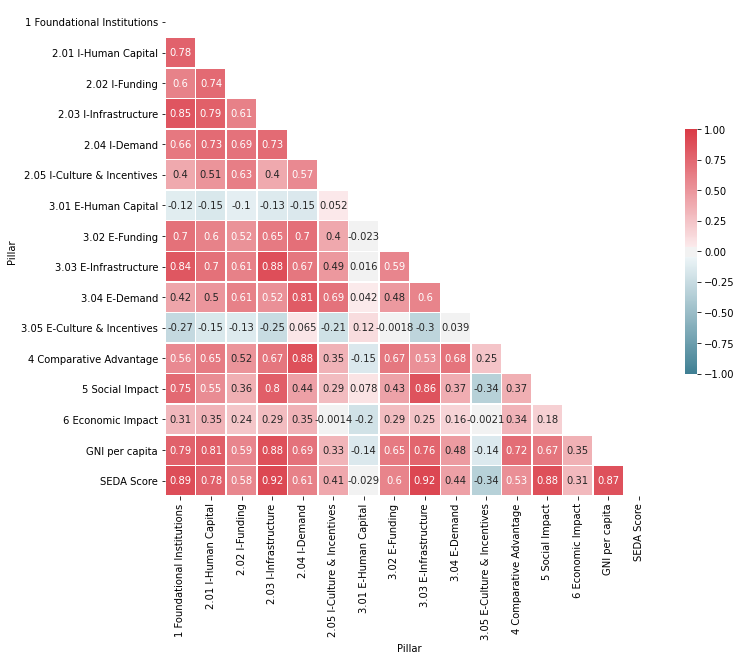

In [12]:
corr = df_grouped.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot = True, cmap=cmap, vmax=1, vmin=-1 ,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Correlation between:  5 Social Impact   and   2.03 I-Infrastructure
**********************************************
Pearson Correlation: 0.7994276720862898, p-value: 9.384198259543387e-25
*Statistically significant*
**********************************************



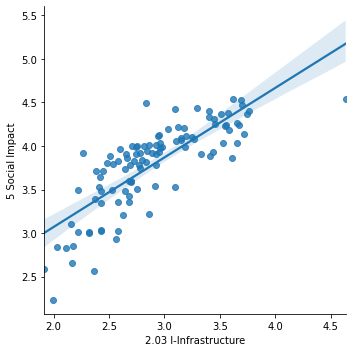

In [13]:
check_corr_significance(df_grouped,'5 Social Impact','2.03 I-Infrastructure')

Reduccion de dimensiones del dataset:

In [14]:
only_iecos = df_grouped.drop(['GNI per capita','SEDA Score'], axis = 1)
only_iecos

Pillar,1 Foundational Institutions,2.01 I-Human Capital,2.02 I-Funding,2.03 I-Infrastructure,2.04 I-Demand,2.05 I-Culture & Incentives,3.01 E-Human Capital,3.02 E-Funding,3.03 E-Infrastructure,3.04 E-Demand,3.05 E-Culture & Incentives,4 Comparative Advantage,5 Social Impact,6 Economic Impact
Country,,,,,,,,,,,,,,
Albania,3.4732,2.205982,1.305845,2.598926,2.929778,1.5660,3.300371,2.041130,3.478800,2.3690,3.103957,2.074467,3.965401,2.738519
Algeria,3.0096,2.195501,1.674710,2.383803,2.573333,2.4276,3.182732,1.738879,3.473333,3.2058,3.351067,2.399133,3.715319,2.324024
Argentina,3.1684,2.051076,1.682002,2.740698,2.729778,1.7930,3.076940,1.725475,3.679067,3.1718,2.891282,2.583067,3.984246,2.405071
Armenia,3.6344,2.238828,1.399669,2.837184,2.718222,1.3420,3.314949,2.167727,3.614267,2.6556,3.512472,2.593067,3.820191,3.070693
Australia,4.3708,2.878032,2.064750,3.294983,3.268889,2.8508,3.752603,2.823880,4.229333,3.4370,3.047026,3.316533,4.440543,3.275445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,4.3396,3.340008,1.967984,3.715226,3.709333,3.9660,2.853192,3.973914,4.286000,3.8236,3.156387,3.884867,4.134732,3.079245
United States,4.2960,3.199162,3.715750,3.606783,4.223556,3.4960,3.722513,4.334513,4.288533,4.3330,3.506775,4.095000,3.863439,3.335960
Uruguay,3.7808,2.234182,1.464989,2.833698,2.578222,1.2428,3.046434,2.006702,3.926000,2.7408,3.051111,2.482667,4.489483,2.605598


In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(only_iecos)
print(f"la varianza explicada es: {np.sum(pca.explained_variance_ratio_)} %")

la varianza explicada es: 0.779306919794318 %


In [16]:
pca.explained_variance_ratio_

array([0.55805165, 0.13517341, 0.08608186])

In [17]:
Components_df = pd.DataFrame({
    "Component_1": pca.components_[0],
    "Component_2": pca.components_[1],
    "Component_3": pca.components_[2],
    "Pilar" : only_iecos.columns})
Components_df.set_index('Pilar',inplace=True)

In [18]:
Components_df['Component_1'].sort_values(ascending=False)

Pilar
2.05 I-Culture & Incentives    0.412142
2.02 I-Funding                 0.361830
2.01 I-Human Capital           0.307039
2.03 I-Infrastructure          0.305492
3.03 E-Infrastructure          0.304912
4 Comparative Advantage        0.282888
3.04 E-Demand                  0.281324
1 Foundational Institutions    0.268109
2.04 I-Demand                  0.260670
3.02 E-Funding                 0.236551
5 Social Impact                0.235053
6 Economic Impact              0.082001
3.01 E-Human Capital          -0.020857
3.05 E-Culture & Incentives   -0.035815
Name: Component_1, dtype: float64

In [19]:
Components_df['Component_2'].sort_values(ascending=False)

Pilar
2.05 I-Culture & Incentives    0.741154
3.04 E-Demand                  0.219509
2.02 I-Funding                 0.148679
3.01 E-Human Capital           0.106619
3.05 E-Culture & Incentives    0.009012
2.04 I-Demand                 -0.017515
2.01 I-Human Capital          -0.124792
3.02 E-Funding                -0.131897
4 Comparative Advantage       -0.151220
6 Economic Impact             -0.191543
3.03 E-Infrastructure         -0.194296
1 Foundational Institutions   -0.253349
2.03 I-Infrastructure         -0.284975
5 Social Impact               -0.304913
Name: Component_2, dtype: float64

In [20]:
Components_df['Component_3'].sort_values(ascending=False)

Pilar
5 Social Impact                0.458906
3.03 E-Infrastructure          0.292411
3.01 E-Human Capital           0.226713
2.05 I-Culture & Incentives    0.213434
1 Foundational Institutions    0.155546
2.03 I-Infrastructure          0.121118
2.01 I-Human Capital          -0.038305
2.02 I-Funding                -0.092369
3.02 E-Funding                -0.157821
3.04 E-Demand                 -0.198337
6 Economic Impact             -0.212529
2.04 I-Demand                 -0.269009
3.05 E-Culture & Incentives   -0.336224
4 Comparative Advantage       -0.513086
Name: Component_3, dtype: float64

In [21]:
Scores = pca.transform(only_iecos)

In [22]:
Score_df = pd.DataFrame({
    "Component_1":Scores[:,0],
    "Component_2": Scores[:,1],
    "Component_3": Scores[:,2],
    "Country" :df.index,
    "Region" :df['Region'],
    "Development" : df['Development Stage']
})

In [23]:
import plotly.express as px
fig = px.scatter_3d(Score_df, x="Component_1", y="Component_2", z='Component_3', color="Development", text = 'Country')
fig.show()

In [39]:
reg = only_iecos.reset_index(drop=True)
reg.columns.name = 'variable'

In [40]:
from pycaret.regression import *
from pycaret.utils import enable_colab 
enable_colab()

Colab mode activated.


In [41]:
reg.head()

variable,1 Foundational Institutions,2.01 I-Human Capital,2.02 I-Funding,2.03 I-Infrastructure,2.04 I-Demand,2.05 I-Culture & Incentives,3.01 E-Human Capital,3.02 E-Funding,3.03 E-Infrastructure,3.04 E-Demand,3.05 E-Culture & Incentives,4 Comparative Advantage,5 Social Impact,6 Economic Impact
0,3.4732,2.205982,1.305845,2.598926,2.929778,1.5660,3.300371,2.041130,3.478800,2.3690,3.103957,2.074467,3.965401,2.738519
1,3.0096,2.195501,1.674710,2.383803,2.573333,2.4276,3.182732,1.738879,3.473333,3.2058,3.351067,2.399133,3.715319,2.324024
2,3.1684,2.051076,1.682002,2.740698,2.729778,1.7930,3.076940,1.725475,3.679067,3.1718,2.891282,2.583067,3.984246,2.405071
3,3.6344,2.238828,1.399669,2.837184,2.718222,1.3420,3.314949,2.167727,3.614267,2.6556,3.512472,2.593067,3.820191,3.070693
4,4.3708,2.878032,2.064750,3.294983,3.268889,2.8508,3.752603,2.823880,4.229333,3.4370,3.047026,3.316533,4.440543,3.275445


Prediccion de impacto social:

In [98]:
reg_ = setup(data = reg, target = '5 Social Impact',train_size=0.8) 

 
Setup Succesfully Completed!


,Description,Value
0,session_id,5959
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(106, 14)"
4,Missing Values,False
5,Numeric Features,13
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [99]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.180800,0.059300,0.230200,0.714900,0.051300,0.051700
1,Extreme Gradient Boosting,0.190000,0.061900,0.237400,0.698300,0.052500,0.053800
2,AdaBoost Regressor,0.190000,0.065200,0.238700,0.698000,0.053500,0.054300
3,Random Forest,0.190600,0.063800,0.237800,0.697400,0.053200,0.054600
4,CatBoost Regressor,0.191000,0.069900,0.245100,0.692800,0.055200,0.055500
5,Support Vector Machine,0.193800,0.063200,0.241100,0.675400,0.054200,0.055800
6,Gradient Boosting Regressor,0.193500,0.069300,0.247200,0.672800,0.055400,0.055200
7,Ridge Regression,0.203500,0.063900,0.245600,0.625700,0.054000,0.057300
8,Bayesian Ridge,0.205500,0.064600,0.247200,0.621700,0.054300,0.057700
9,TheilSen Regressor,0.213700,0.069800,0.254700,0.614900,0.055800,0.060300


In [100]:
et_1 = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2232,0.0616,0.2482,0.6947,0.0542,0.0634
1,0.2360,0.1080,0.3286,0.6952,0.0813,0.0803
2,0.1191,0.0311,0.1762,0.8353,0.0349,0.0302
3,0.1040,0.0253,0.1590,0.8361,0.0345,0.0285
4,0.3007,0.1454,0.3813,0.7237,0.0927,0.0941
5,0.1934,0.0667,0.2583,0.5505,0.0561,0.0545
6,0.0956,0.0126,0.1124,0.4855,0.0228,0.0240
7,0.1607,0.0352,0.1876,0.8488,0.0429,0.0448
8,0.2265,0.0778,0.2790,0.7125,0.0604,0.0614
9,0.1489,0.0294,0.1714,0.7666,0.0328,0.0355


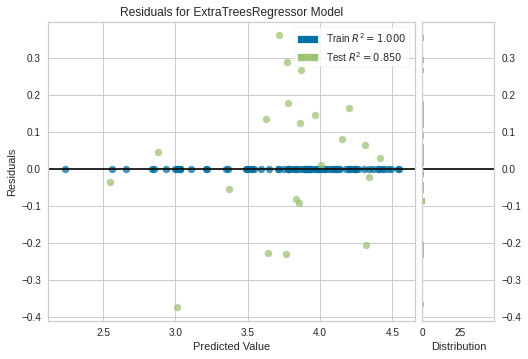

In [101]:
plot_model(et_1)

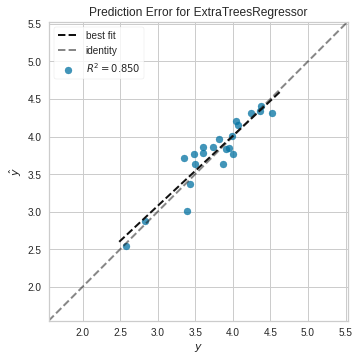

In [102]:
plot_model(et_1,'error')

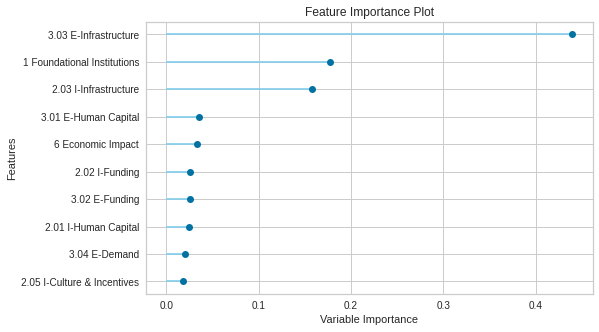

In [103]:
plot_model(et_1,'feature')

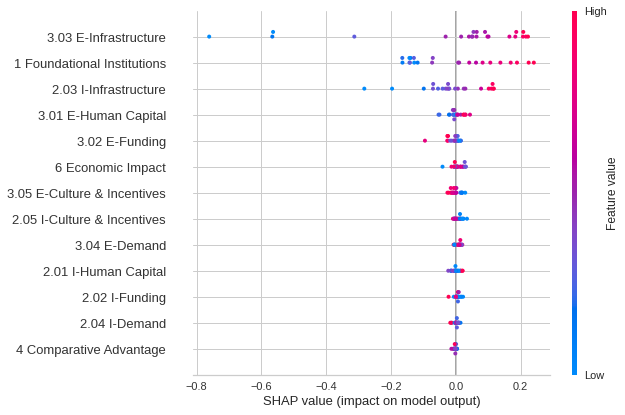

In [104]:
interpret_model(et_1)

Prediccion Impacto economico:

In [105]:
reg_2 = setup(data = reg, target = '6 Economic Impact',train_size=0.8) 

 
Setup Succesfully Completed!


,Description,Value
0,session_id,2048
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(106, 14)"
4,Missing Values,False
5,Numeric Features,13
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [106]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.279000,0.128300,0.347500,0.039600,0.087800,0.096100
1,Light Gradient Boosting Machine,0.274000,0.125100,0.344600,0.018600,0.087100,0.094800
2,Random Forest,0.283000,0.130100,0.350800,0.008300,0.088500,0.097200
3,CatBoost Regressor,0.284100,0.132800,0.353700,-0.011400,0.089400,0.097900
4,K Neighbors Regressor,0.279000,0.132300,0.351900,-0.048400,0.088700,0.096700
5,Extreme Gradient Boosting,0.290900,0.139000,0.362300,-0.055700,0.091800,0.100200
6,Bayesian Ridge,0.289100,0.140000,0.361900,-0.066000,0.092000,0.100600
7,Support Vector Machine,0.288700,0.138000,0.361600,-0.075700,0.091600,0.099900
8,Extra Trees Regressor,0.295800,0.141500,0.366500,-0.080500,0.092500,0.102300
9,Orthogonal Matching Pursuit,0.291500,0.147500,0.369700,-0.125000,0.094000,0.101000


In [113]:
lgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3204,0.1650,0.4061,-0.3061,0.0951,0.0953
1,0.2459,0.1009,0.3176,0.3280,0.0800,0.0823
2,0.2779,0.1370,0.3701,0.0413,0.0870,0.0835
3,0.3905,0.2664,0.5161,-0.4272,0.1433,0.1695
4,0.2563,0.0857,0.2928,0.3448,0.0768,0.0924
5,0.3127,0.1299,0.3604,0.1398,0.0890,0.0991
6,0.1786,0.0463,0.2152,0.4398,0.0557,0.0638
7,0.2349,0.0856,0.2925,-0.6298,0.0720,0.0766
8,0.3216,0.1542,0.3927,0.2618,0.0986,0.1108
9,0.2016,0.0797,0.2823,-0.0064,0.0738,0.0750


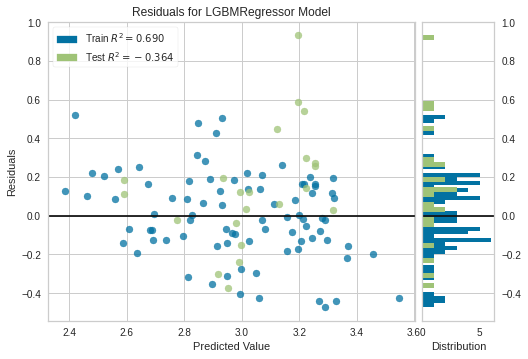

In [114]:
plot_model(lgbm)

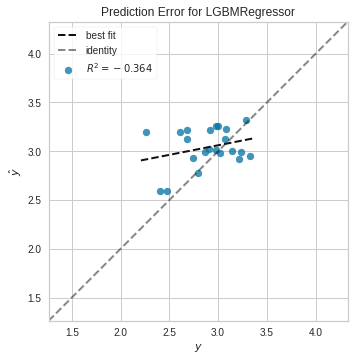

In [115]:
plot_model(lgbm,plot='error')

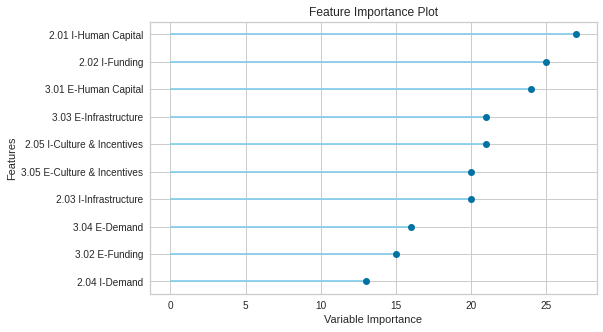

In [116]:
plot_model(lgbm,'feature')

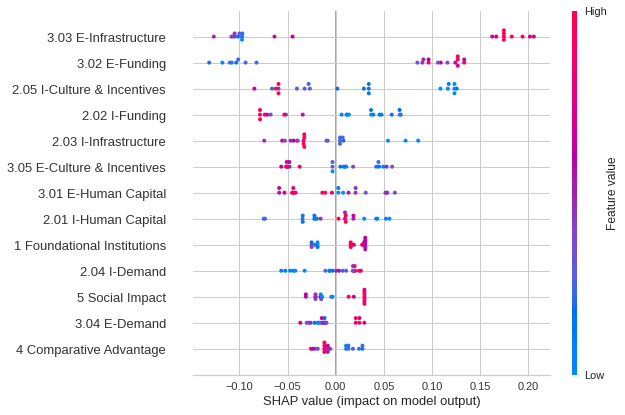

In [117]:
interpret_model(lgbm)